# Conditional GAN for Image-to-Image Translation (Pix2Pix) on the Cityscapes Dataset

This notebook demonstrates the Pix2Pix framework, a Conditional GAN (cGAN) approach, on the Cityscapes dataset. We train a Generator (G) to map from a segmentation map (condition) to a realistic street image (target), while a Discriminator (D) tries to distinguish between real and generated images conditioned on the input.

The overall objective combines an adversarial loss with an L1 reconstruction loss to encourage both realism and faithfulness to the input condition.


## Importing Libraries

We first import necessary libraries including TensorFlow, Matplotlib, and more. Also, we ensure GPU availability for faster training.


In [1]:
%matplotlib inline
import tensorflow as tf
import os
import time
import glob
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm


In [2]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 1


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/cityscapes-pix2pix-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cityscapes-pix2pix-dataset


## Set Paths and Parameters

We define the dataset paths, training parameters, and hyperparametere.


In [29]:
ORIGINAL_DATA_DIR = "/kaggle/input/cityscapes-pix2pix-dataset"
CHECKPOINT_DIR = "./checkpoints/"
OUTPUT_DIR = "./output_images/"

!mkdir checkpoints
!mkdir output_images

BUFFER_DIM = 400
BATCH_DIM = 1
IMG_SIZE = 256
LAMBDA = 100
EPOCH_COUNT = 50


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Load the Dataset
T the dataset is composed of paired images (segmentation map | real image) concatenated side by side. The training and validation sets are defineds.


In [5]:
TRAIN_PATTERN = os.path.join(ORIGINAL_DATA_DIR, "train/*.jpg")
TEST_PATTERN = os.path.join(ORIGINAL_DATA_DIR, "val/*.jpg")

train_files = tf.io.gfile.glob(TRAIN_PATTERN)
test_files = tf.io.gfile.glob(TEST_PATTERN)

print("Number of train images:", len(train_files))
print("Number of test images:", len(test_files))


Number of train images: 2975
Number of test images: 500


## Data Preprocessing

We define functions to parse the input images, split them into condition and target, normalize them to [-1,1], and apply random jitter (resize, crop, flip) for data augmentation during trainin

- Input: Right side (segmentation)
- Target: Left side (real)g.


In [31]:
def parse_image(file_path):
    img_content = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img_content)
    w = tf.shape(img)[1]
    w_split = w // 2
    
    # Right side = segmentation (input)
    input_img = img[:, w_split:, :]
    # Left side = real (target)
    target_img = img[:, :w_split, :]
    
    input_img = tf.cast(input_img, tf.float32)
    target_img = tf.cast(target_img, tf.float32)
    return input_img, target_img


def normalize_data(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image

def random_jitter(input_image, target_image):
    # Resize to 286x286 before random cropping
    input_image = tf.image.resize(input_image, [286, 286],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    target_image = tf.image.resize(target_image, [286, 286],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Random crop to 256x256
    stacked = tf.stack([input_image, target_image], axis=0)
    cropped = tf.image.random_crop(stacked, size=[2, IMG_SIZE, IMG_SIZE, 3])
    input_image, target_image = cropped[0], cropped[1]

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        target_image = tf.image.flip_left_right(target_image)

    return input_image, target_image

def load_train_example(file_path):
    inp, tar = parse_image(file_path)
    inp, tar = random_jitter(inp, tar)
    inp, tar = normalize_data(inp, tar)
    return inp, tar

def load_test_example(file_path):
    inp, tar = parse_image(file_path)
    inp = tf.image.resize(inp, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    tar = tf.image.resize(tar, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    inp, tar = normalize_data(inp, tar)
    return inp, tar


## Create Training and Testing Datasets

We now create `tf.data.Dataset` objects for the training and testing sets, applying the above functions and batching.


In [47]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(load_train_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_DIM)
train_ds = train_ds.batch(BATCH_DIM)

val_ds = tf.data.Dataset.from_tensor_slices(test_files)
val_ds = val_ds.map(load_test_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_DIM)


## Visualizing Some Samples Before Training

Before we begin training, let's take a look at a few samples from the dataset. This helps us understand what the input and target pairs look like after our preprocessing.


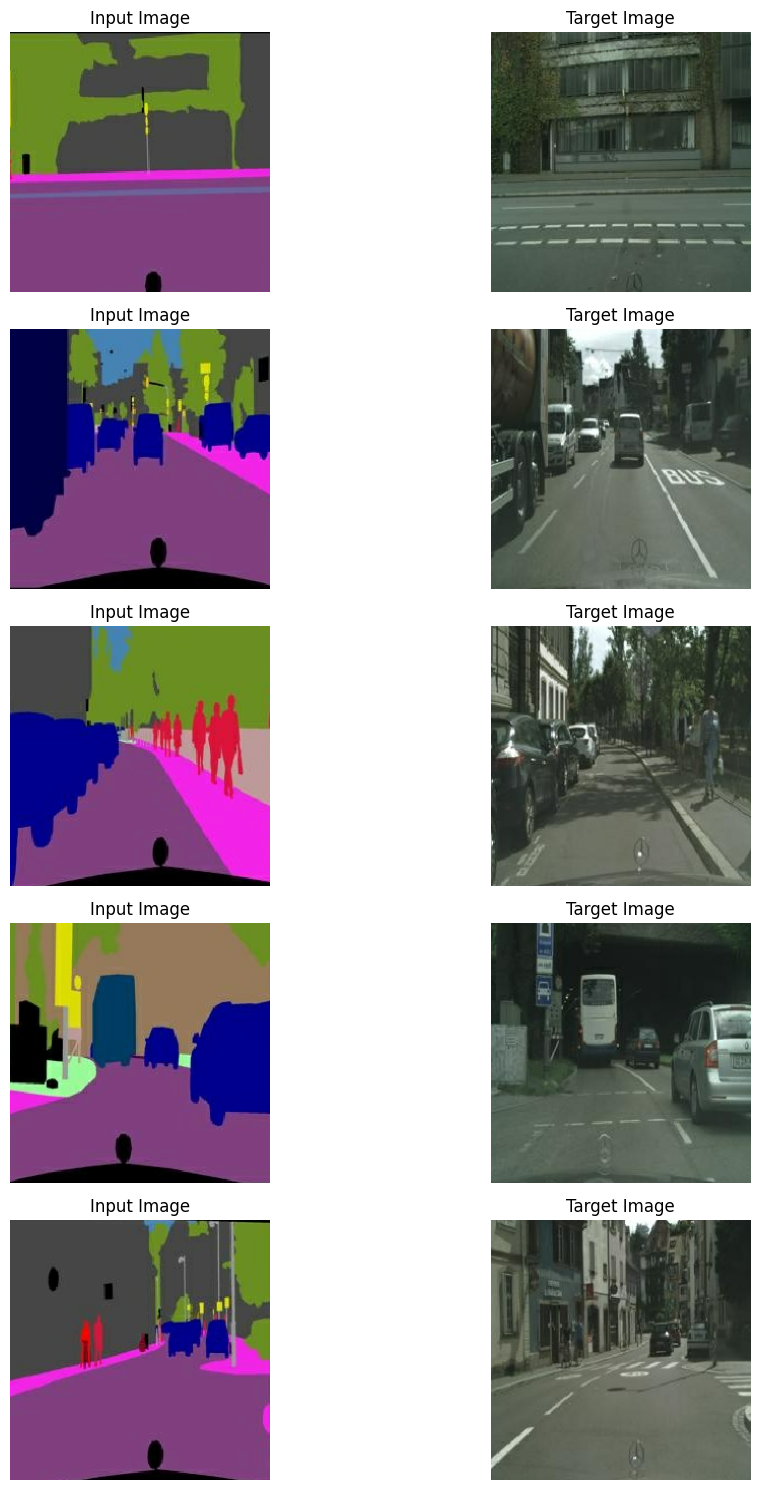

In [48]:
def plot_dataset_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 3*num_samples))
    for i, (inp, tar) in enumerate(dataset.take(num_samples)):
        # Display input image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.title("Input Image")
        plt.imshow((inp[0]*0.5)+0.5)  # De-normalize for display
        plt.axis('off')

        # Display target image
        plt.subplot(num_samples, 2, 2*i+2)
        plt.title("Target Image")
        plt.imshow((tar[0]*0.5)+0.5)  # De-normalize for display
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 5 samples
plot_dataset_samples(train_ds, num_samples=5)


## Visualization Helper
We implement this functionon to visualize input, generated output, and ground truth side by side for comparison.


In [59]:
def display_samples(model, test_input, ground_truth):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], ground_truth[0], prediction[0]]
    titles = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow((display_list[i] * 0.5) + 0.5)
        plt.axis('off')
    plt.show()


## Model Architectures

We implement the U-Net-based Generator and a PatchGAN-based Discriminator as in the Pix2Pix paper.

**Generator (U-Net):**
- Uses an encoder-decoder structure with skip connections.
- Downsampling layers (encoder) reduce spatial dimensions and increase depth.
- Upsampling layers (decoder) reconstruct the image, using skip connections from the encoder.

**Discriminator (PatchGAN):**
- Evaluates realism in a patch-wise manner.
- Takes both input and generated/real target as inputs.


In [50]:
def create_downsample(filters, size, apply_batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    layer = tf.keras.Sequential()
    layer.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                     kernel_initializer=init, use_bias=False))
    if apply_batchnorm:
        layer.add(tf.keras.layers.BatchNormalization())
    layer.add(tf.keras.layers.LeakyReLU())
    return layer

def create_upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    up_layer = tf.keras.Sequential()
    up_layer.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=init,
                                        use_bias=False))
    up_layer.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        up_layer.add(tf.keras.layers.Dropout(0.5))
    up_layer.add(tf.keras.layers.ReLU())
    return up_layer

def build_generator():
    down_stack = [
        create_downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        create_downsample(128, 4),                        # (bs, 64, 64, 128)
        create_downsample(256, 4),                        # (bs, 32, 32, 256)
        create_downsample(512, 4),                        # (bs, 16, 16, 512)
        create_downsample(512, 4),                        # (bs, 8, 8, 512)
        create_downsample(512, 4),                        # (bs, 4, 4, 512)
        create_downsample(512, 4),                        # (bs, 2, 2, 512)
        create_downsample(512, 4),                        # (bs, 1, 1, 512)
    ]

    up_stack = [
        create_upsample(512, 4, apply_dropout=True),      # (bs, 2, 2, 1024)
        create_upsample(512, 4, apply_dropout=True),      # (bs, 4, 4, 1024)
        create_upsample(512, 4, apply_dropout=True),      # (bs, 8, 8, 1024)
        create_upsample(512, 4),                          # (bs, 16, 16, 1024)
        create_upsample(256, 4),                          # (bs, 32, 32, 512)
        create_upsample(128, 4),                          # (bs, 64, 64, 256)
        create_upsample(64, 4),                           # (bs, 128, 128, 128)
    ]

    init = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = inputs

    # Encoder: collect intermediate steps for skip connections
    skips = []
    # Use all down_stack layers except the last one for the encoder part
    for down in down_stack[:-1]:
        x = down(x)
        skips.append(x)

    # The final downsampling layer (bottleneck)
    x = down_stack[-1](x)

    # Reverse the order of skip connections to use them during upsampling
    skips = skips[::-1]

    # Decoder: upsampling + skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Final output layer
    last_layer = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh')
    x = last_layer(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



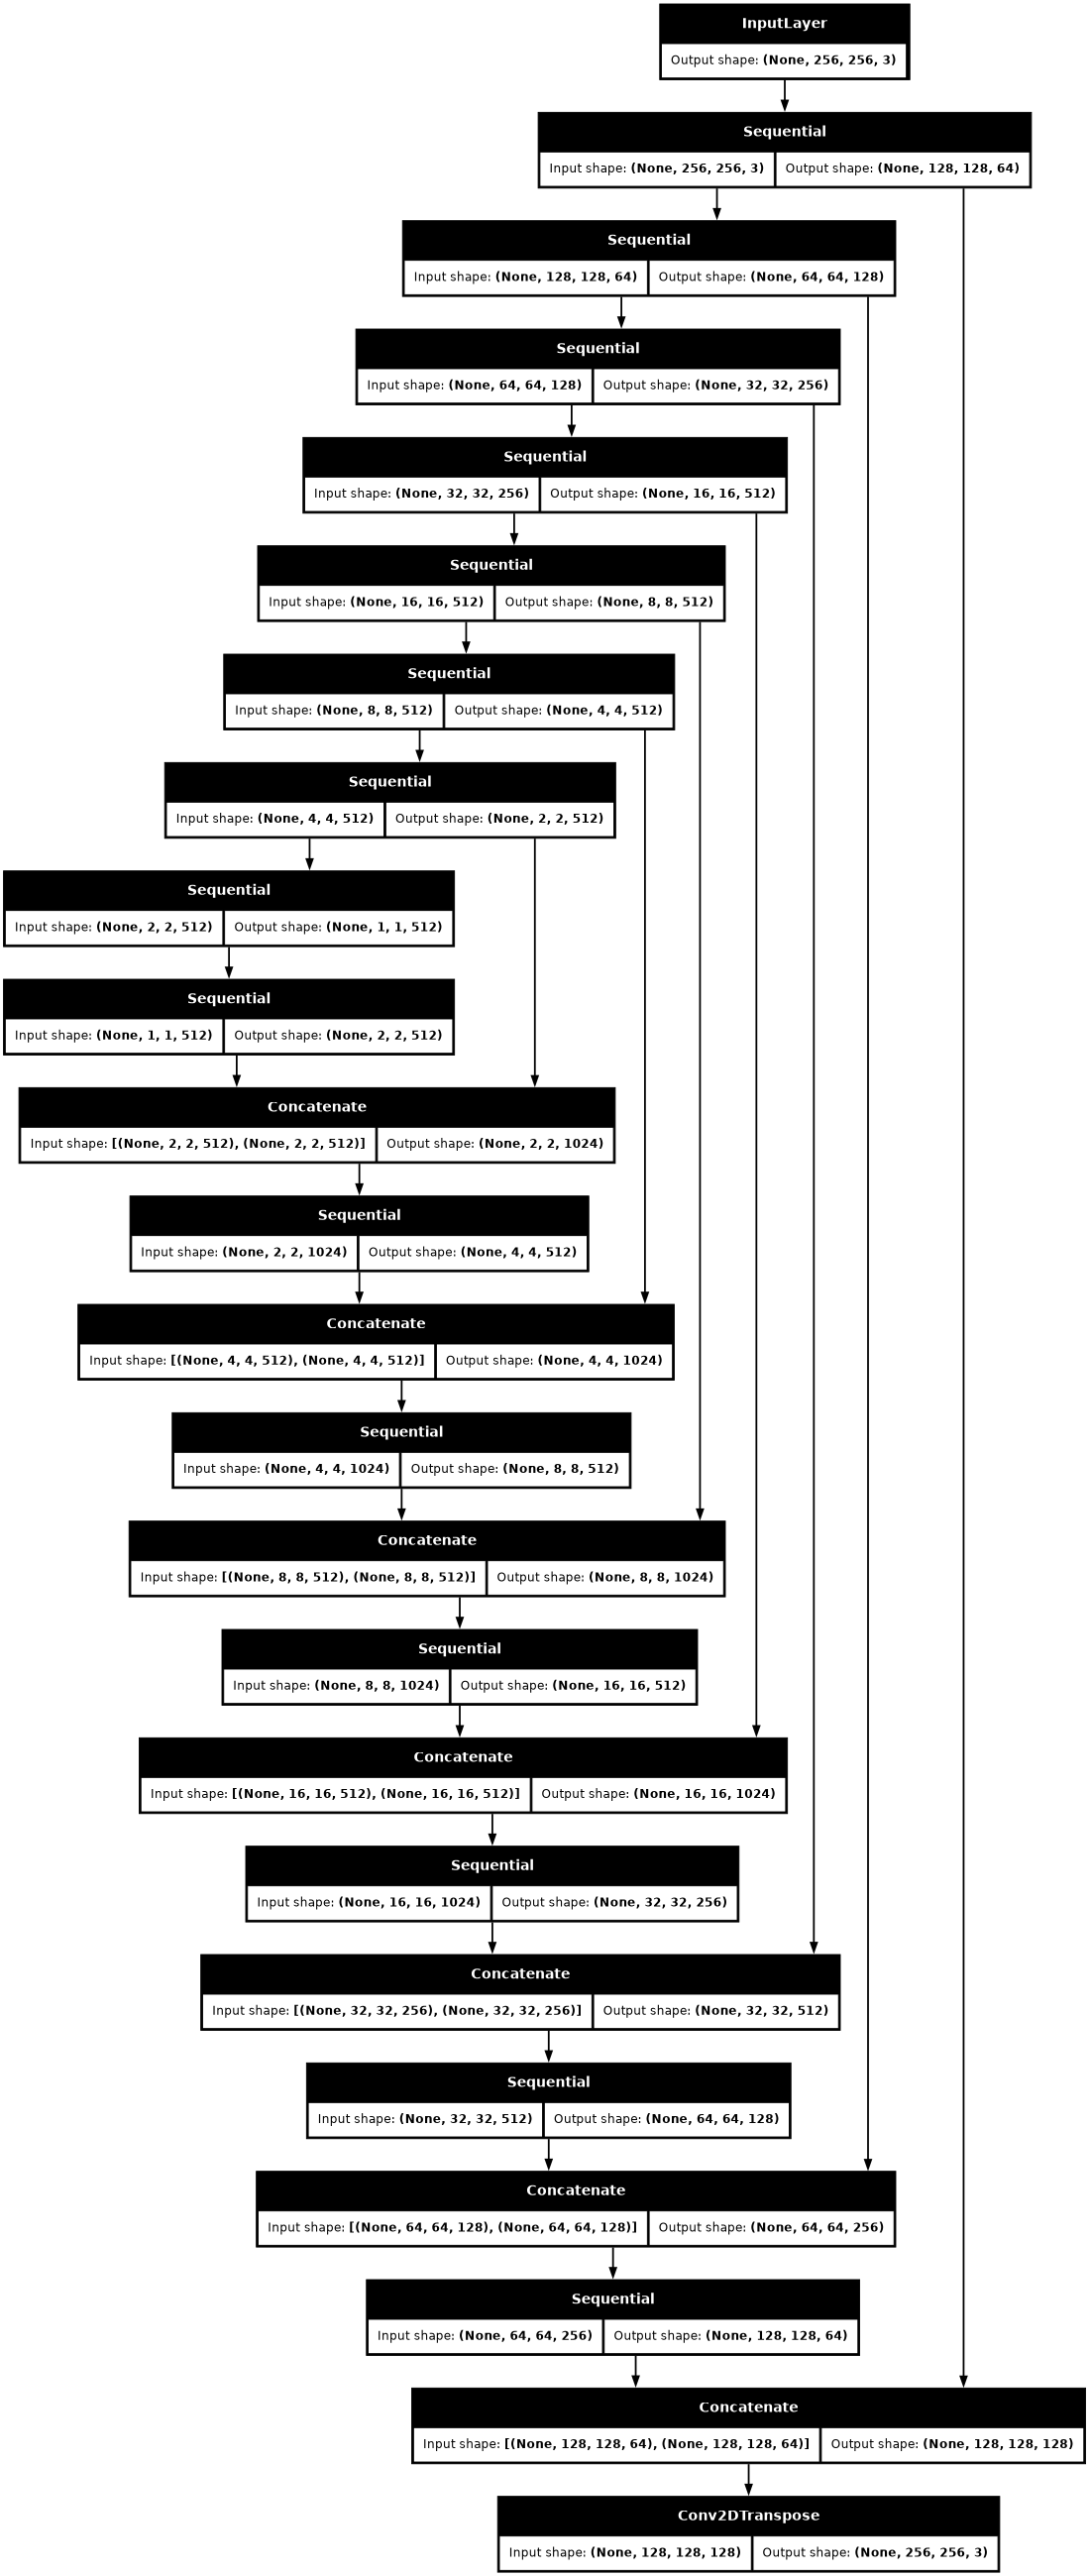

In [51]:
generator_model = build_generator()
tf.keras.utils.plot_model(generator_model, show_shapes=True, dpi=64)


## Discriminator

The Discriminator receives the input image and either a real or generated target image. It returns a patch-level classification output.


In [52]:
def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    in_image = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='input_image')
    tar_image = tf.keras.layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3], name='target_image')

    combined = tf.keras.layers.Concatenate()([in_image, tar_image])

    down1 = create_downsample(64, 4, False)(combined)
    down2 = create_downsample(128, 4)(down1)
    down3 = create_downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=init,
                                  use_bias=False)(zero_pad1)

    norm = tf.keras.layers.BatchNormalization()(conv)
    leaky = tf.keras.layers.LeakyReLU()(norm)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky)
    final = tf.keras.layers.Conv2D(1, 4, strides=1,
                                   kernel_initializer=init)(zero_pad2)

    return tf.keras.Model(inputs=[in_image, tar_image], outputs=final)


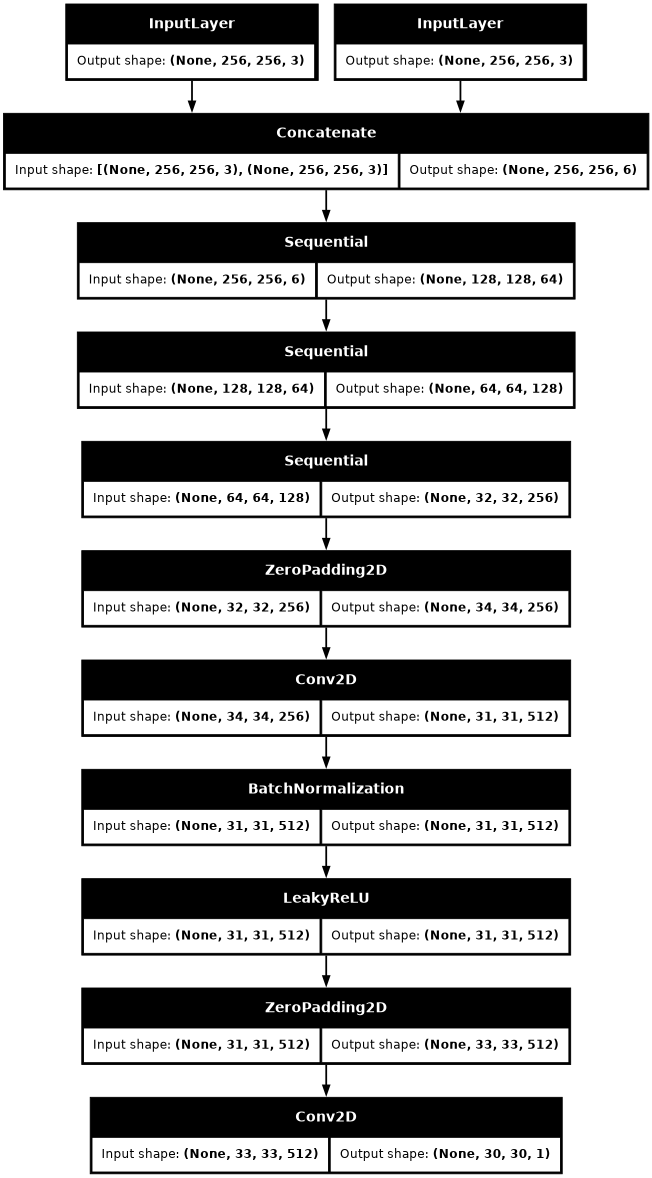

In [53]:
discriminator_model = build_discriminator()
tf.keras.utils.plot_model(discriminator_model, show_shapes=True, dpi=64)


## Loss Functions

We use two main losses:

1. **Adversarial Loss (GAN Loss)**:
   For the Discriminator, we want:
   - Real images to yield outputs close to 1
   - Fake (generated) images to yield outputs close to 0

   For the Generator, it aims to fool the Discriminator, producing outputs that are classified as real:
   $$ L_{GAN}(G) = \mathbb{E}_{x,z}[-\log(D(x,G(x,z)))] $$

2. **L1 Loss**:
   To encourage the generated image to match the target image, we add an L1 penalty:
   $$ L_{L1}(G) = \mathbb{E}_{x,y,z}[||y - G(x,z)||_1] $$

Combined Generator Loss:
$$ L_G = L_{GAN}(G) + \lambda L_{L1}(G) $$

Where $\lambda = 100$.


In [54]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_out, disc_generated_out):
    real_loss = loss_object(tf.ones_like(disc_real_out), disc_real_out)
    fake_loss = loss_object(tf.zeros_like(disc_generated_out), disc_generated_out)
    return (real_loss + fake_loss) * 0.5

def generator_loss(disc_generated_out, generated_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_out), disc_generated_out)
    l1_loss_val = tf.reduce_mean(tf.abs(target - generated_output))
    total_loss = gan_loss + (LAMBDA * l1_loss_val)
    return total_loss


## Optimizers and Checkpoints

We use the Adam optimizer with a learning rate of 2e-4 and β1=0.5 for both generator and discriminator. We also set up checkpoints to save and restore models during training.


In [55]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)


## Training Step

During each training step, we:
- Generate an image from the generator
- Pass both real and generated images through the discriminator
- Compute the generator and discriminator losses
- Update parameters using backpropagation


In [56]:
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_img = generator_model(input_img, training=True)

        disc_real = discriminator_model([input_img, target_img], training=True)
        disc_fake = discriminator_model([input_img, generated_img], training=True)

        gen_loss_val = generator_loss(disc_fake, generated_img, target_img)
        disc_loss_val = discriminator_loss(disc_real, disc_fake)

    generator_gradients = gen_tape.gradient(gen_loss_val, generator_model.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss_val, discriminator_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))

    return gen_loss_val, disc_loss_val


## Generate and Save Images

At the end of each epoch, we generate and save sample predictions to visually track progress.


In [57]:
def generate_and_save_images(model, test_input, tar, epoch_id):
    pred = model(test_input, training=True)
    fig = plt.figure(figsize=(15,15))

    view_list = [test_input[0], tar[0], pred[0]]
    label_list = ['Input', 'Ground Truth', 'Prediction']

    for i, elem in enumerate(view_list):
        plt.subplot(1, 3, i+1)
        plt.title(label_list[i])
        plt.imshow((elem * 0.5) + 0.5)
        plt.axis('off')
    plt.savefig(OUTPUT_DIR + 'image_at_epoch_{:04d}.png'.format(epoch_id))
    plt.show()


## Training Loop

We run several epochs over the training dataset. Each epoch:
1. Iterates over the entire training set.
2. Prints progress and losses.
3. Generates sample and saves model checkpoints.

In [62]:
# Lists to store losses per epoch
gen_loss_train_history = []
disc_loss_train_history = []
gen_loss_val_history = []
disc_loss_val_history = []

def compute_val_losses(val_dataset):
    gen_losses = []
    disc_losses = []
    for inp, tar in val_dataset:
        # Generate image
        generated_img = generator_model(inp, training=False)
        
        # Discriminator predictions
        disc_real = discriminator_model([inp, tar], training=False)
        disc_fake = discriminator_model([inp, generated_img], training=False)
        
        # Compute losses
        g_loss = generator_loss(disc_fake, generated_img, tar)
        d_loss = discriminator_loss(disc_real, disc_fake)
        
        gen_losses.append(g_loss.numpy())
        disc_losses.append(d_loss.numpy())
    
    return (sum(gen_losses)/len(gen_losses), sum(disc_losses)/len(disc_losses))

def train_model(dataset, val_dataset, epochs):
    example_input, example_target = next(iter(val_dataset))
    start = time.time()

    for ep in range(epochs):
        print(f"Starting epoch {ep+1}/{epochs}")

        # Track train losses per epoch
        epoch_gen_losses = []
        epoch_disc_losses = []

        from tqdm import tqdm
        step_bar = tqdm(dataset, desc=f"Epoch {ep+1}/{epochs}", unit='batch')
        for inp, tar in step_bar:
            g_loss, d_loss = train_step(inp, tar)
            epoch_gen_losses.append(g_loss.numpy())
            epoch_disc_losses.append(d_loss.numpy())
            step_bar.set_postfix(GenLoss=float(g_loss.numpy()), DiscLoss=float(d_loss.numpy()))

        # Compute average training losses for this epoch
        avg_gen_loss_train = sum(epoch_gen_losses)/len(epoch_gen_losses)
        avg_disc_loss_train = sum(epoch_disc_losses)/len(epoch_disc_losses)
        
        # Store training losses
        gen_loss_train_history.append(avg_gen_loss_train)
        disc_loss_train_history.append(avg_disc_loss_train)

        # Compute validation losses
        avg_gen_loss_val, avg_disc_loss_val = compute_val_losses(val_dataset)
        gen_loss_val_history.append(avg_gen_loss_val)
        disc_loss_val_history.append(avg_disc_loss_val)

        
        if ep == 0 or (ep+1) % 10 == 0:
            generate_and_save_images(generator_model, example_input, example_target, ep+1)

        # Save checkpoint
        manager.save()
        print(f"Epoch {ep+1} completed in {time.time()-start:.2f} sec")

    print("Training completed.")


## Start Training

We now run the training loop for the defined number of epochs.


Starting epoch 1/50


Epoch 1/50: 100%|██████████| 2975/2975 [03:23<00:00, 14.65batch/s, DiscLoss=0.725, GenLoss=16.5] 


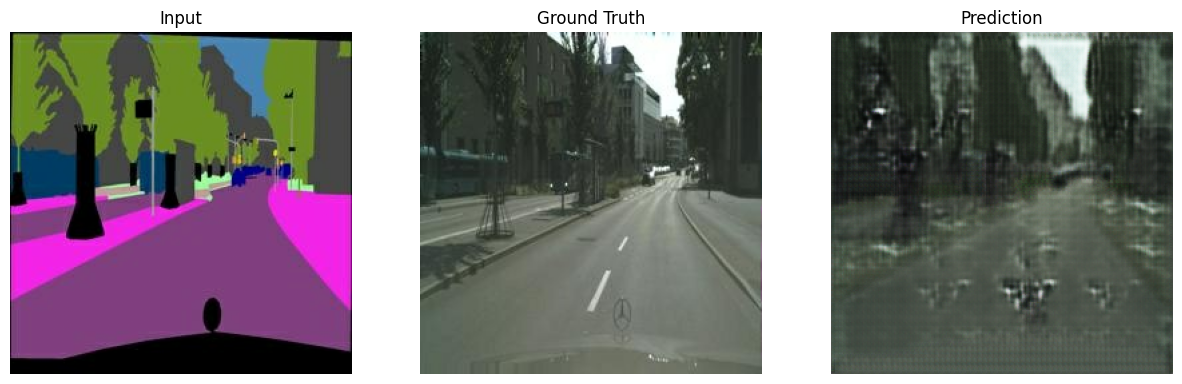

Epoch 1 completed in 241.86 sec
Starting epoch 2/50


Epoch 2/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.29batch/s, DiscLoss=0.247, GenLoss=22.1] 


Epoch 2 completed in 473.99 sec
Starting epoch 3/50


Epoch 3/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.28batch/s, DiscLoss=0.0611, GenLoss=29.5]


Epoch 3 completed in 705.98 sec
Starting epoch 4/50


Epoch 4/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.23batch/s, DiscLoss=0.307, GenLoss=19.3] 


Epoch 4 completed in 938.78 sec
Starting epoch 5/50


Epoch 5/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.23batch/s, DiscLoss=0.275, GenLoss=16.4] 


Epoch 5 completed in 1171.74 sec
Starting epoch 6/50


Epoch 6/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.20batch/s, DiscLoss=0.354, GenLoss=15.8] 


Epoch 6 completed in 1405.37 sec
Starting epoch 7/50


Epoch 7/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.20batch/s, DiscLoss=0.0744, GenLoss=24.2]


Epoch 7 completed in 1638.63 sec
Starting epoch 8/50


Epoch 8/50: 100%|██████████| 2975/2975 [03:16<00:00, 15.18batch/s, DiscLoss=0.42, GenLoss=19.8]   


Epoch 8 completed in 1872.45 sec
Starting epoch 9/50


Epoch 9/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.25batch/s, DiscLoss=0.22, GenLoss=25.9]  


Epoch 9 completed in 2104.96 sec
Starting epoch 10/50


Epoch 10/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.24batch/s, DiscLoss=0.544, GenLoss=20.5] 


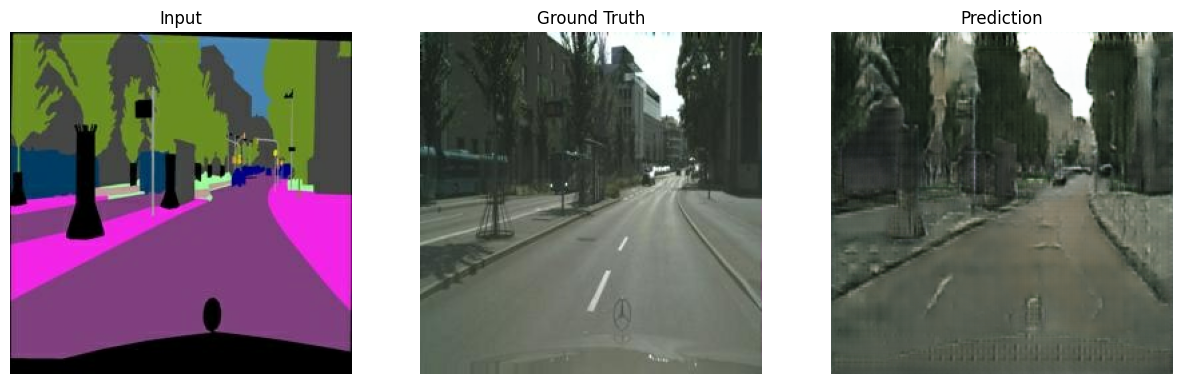

Epoch 10 completed in 2338.68 sec
Starting epoch 11/50


Epoch 11/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.25batch/s, DiscLoss=0.118, GenLoss=21.8] 


Epoch 11 completed in 2571.16 sec
Starting epoch 12/50


Epoch 12/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.28batch/s, DiscLoss=0.548, GenLoss=32.9]  


Epoch 12 completed in 2803.08 sec
Starting epoch 13/50


Epoch 13/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.33batch/s, DiscLoss=0.531, GenLoss=15.6]  


Epoch 13 completed in 3034.33 sec
Starting epoch 14/50


Epoch 14/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.18batch/s, DiscLoss=0.972, GenLoss=18.2] 


Epoch 14 completed in 3268.35 sec
Starting epoch 15/50


Epoch 15/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.23batch/s, DiscLoss=0.0616, GenLoss=25.3]


Epoch 15 completed in 3501.38 sec
Starting epoch 16/50


Epoch 16/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.31batch/s, DiscLoss=0.254, GenLoss=28.3] 


Epoch 16 completed in 3732.84 sec
Starting epoch 17/50


Epoch 17/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.32batch/s, DiscLoss=0.423, GenLoss=19.9] 


Epoch 17 completed in 3964.20 sec
Starting epoch 18/50


Epoch 18/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.30batch/s, DiscLoss=0.594, GenLoss=20.7] 


Epoch 18 completed in 4196.39 sec
Starting epoch 19/50


Epoch 19/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.26batch/s, DiscLoss=1.04, GenLoss=20.8]   


Epoch 19 completed in 4428.99 sec
Starting epoch 20/50


Epoch 20/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.26batch/s, DiscLoss=0.0684, GenLoss=26.4] 


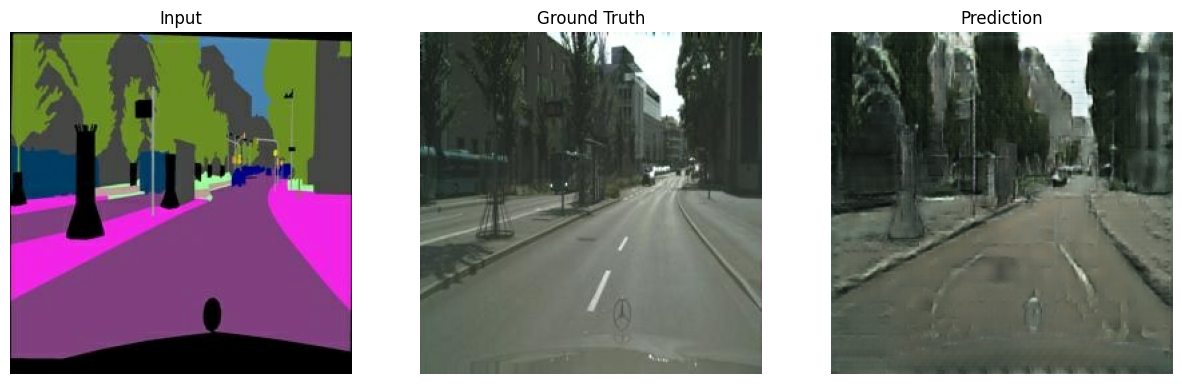

Epoch 20 completed in 4662.44 sec
Starting epoch 21/50


Epoch 21/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.34batch/s, DiscLoss=0.879, GenLoss=13.8] 


Epoch 21 completed in 4893.23 sec
Starting epoch 22/50


Epoch 22/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.29batch/s, DiscLoss=0.384, GenLoss=19.1] 


Epoch 22 completed in 5125.77 sec
Starting epoch 23/50


Epoch 23/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.25batch/s, DiscLoss=0.195, GenLoss=20.4] 


Epoch 23 completed in 5359.03 sec
Starting epoch 24/50


Epoch 24/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.25batch/s, DiscLoss=0.73, GenLoss=22.2]  


Epoch 24 completed in 5591.90 sec
Starting epoch 25/50


Epoch 25/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.28batch/s, DiscLoss=0.67, GenLoss=19.6]  


Epoch 25 completed in 5824.03 sec
Starting epoch 26/50


Epoch 26/50: 100%|██████████| 2975/2975 [03:15<00:00, 15.24batch/s, DiscLoss=1.77, GenLoss=16]    


Epoch 26 completed in 6057.27 sec
Starting epoch 27/50


Epoch 27/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.26batch/s, DiscLoss=0.286, GenLoss=22.3] 


Epoch 27 completed in 6289.90 sec
Starting epoch 28/50


Epoch 28/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.30batch/s, DiscLoss=0.133, GenLoss=29]   


Epoch 28 completed in 6521.44 sec
Starting epoch 29/50


Epoch 29/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.38batch/s, DiscLoss=0.73, GenLoss=25.5]   


Epoch 29 completed in 6752.22 sec
Starting epoch 30/50


Epoch 30/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.35batch/s, DiscLoss=0.275, GenLoss=22.6] 


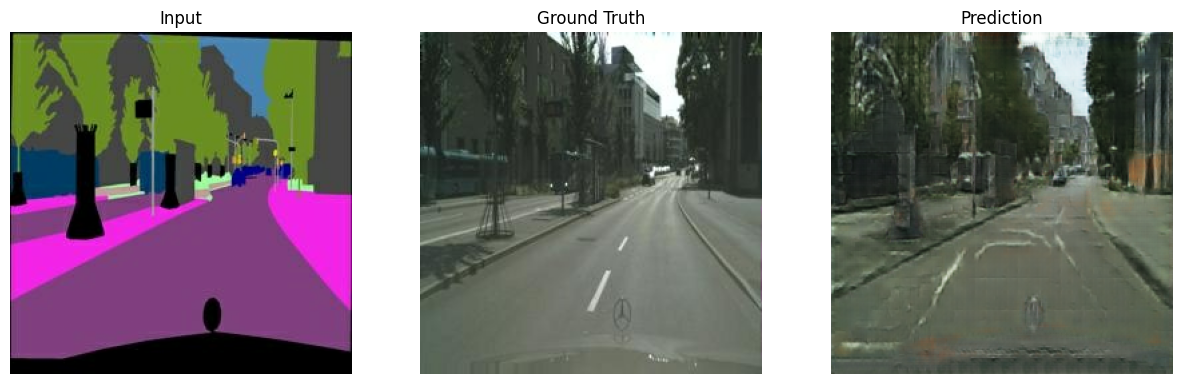

Epoch 30 completed in 6984.15 sec
Starting epoch 31/50


Epoch 31/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.35batch/s, DiscLoss=0.344, GenLoss=17]   


Epoch 31 completed in 7215.64 sec
Starting epoch 32/50


Epoch 32/50: 100%|██████████| 2975/2975 [03:16<00:00, 15.16batch/s, DiscLoss=1.47, GenLoss=16.2]  


Epoch 32 completed in 7448.81 sec
Starting epoch 33/50


Epoch 33/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=0.344, GenLoss=18.7] 


Epoch 33 completed in 7679.50 sec
Starting epoch 34/50


Epoch 34/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.38batch/s, DiscLoss=0.36, GenLoss=14]    


Epoch 34 completed in 7910.08 sec
Starting epoch 35/50


Epoch 35/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=0.999, GenLoss=15.6] 


Epoch 35 completed in 8140.73 sec
Starting epoch 36/50


Epoch 36/50: 100%|██████████| 2975/2975 [03:14<00:00, 15.31batch/s, DiscLoss=0.71, GenLoss=15.9]  


Epoch 36 completed in 8372.30 sec
Starting epoch 37/50


Epoch 37/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.40batch/s, DiscLoss=0.036, GenLoss=35.3] 


Epoch 37 completed in 8602.70 sec
Starting epoch 38/50


Epoch 38/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.38batch/s, DiscLoss=0.475, GenLoss=20.9] 


Epoch 38 completed in 8833.23 sec
Starting epoch 39/50


Epoch 39/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.39batch/s, DiscLoss=0.424, GenLoss=19.3] 


Epoch 39 completed in 9063.59 sec
Starting epoch 40/50


Epoch 40/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.34batch/s, DiscLoss=0.286, GenLoss=16.3] 


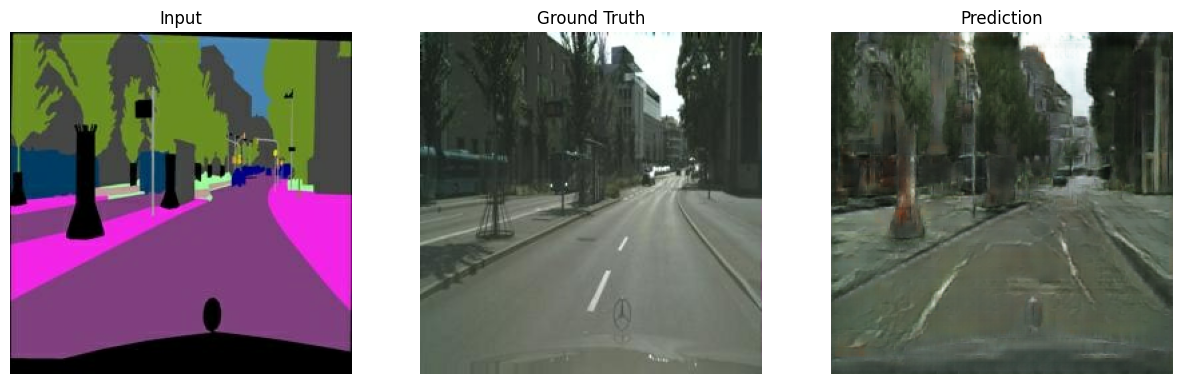

Epoch 40 completed in 9295.55 sec
Starting epoch 41/50


Epoch 41/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=1.1, GenLoss=16.3]   


Epoch 41 completed in 9526.31 sec
Starting epoch 42/50


Epoch 42/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.36batch/s, DiscLoss=0.297, GenLoss=15.4] 


Epoch 42 completed in 9757.22 sec
Starting epoch 43/50


Epoch 43/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=0.26, GenLoss=20.9]  


Epoch 43 completed in 9987.99 sec
Starting epoch 44/50


Epoch 44/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.36batch/s, DiscLoss=0.304, GenLoss=15.1] 


Epoch 44 completed in 10218.89 sec
Starting epoch 45/50


Epoch 45/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.40batch/s, DiscLoss=0.299, GenLoss=21.4] 


Epoch 45 completed in 10449.17 sec
Starting epoch 46/50


Epoch 46/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.40batch/s, DiscLoss=0.451, GenLoss=16.8] 


Epoch 46 completed in 10679.49 sec
Starting epoch 47/50


Epoch 47/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=0.939, GenLoss=21.6] 


Epoch 47 completed in 10910.24 sec
Starting epoch 48/50


Epoch 48/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.37batch/s, DiscLoss=0.367, GenLoss=18.2] 


Epoch 48 completed in 11141.22 sec
Starting epoch 49/50


Epoch 49/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.38batch/s, DiscLoss=0.228, GenLoss=24.1] 


Epoch 49 completed in 11371.79 sec
Starting epoch 50/50


Epoch 50/50: 100%|██████████| 2975/2975 [03:13<00:00, 15.38batch/s, DiscLoss=0.317, GenLoss=15.7]  


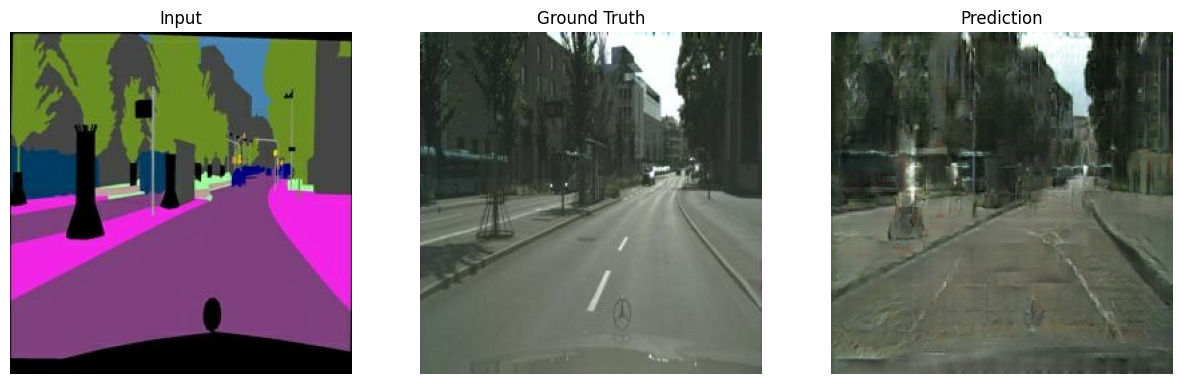

Epoch 50 completed in 11603.16 sec
Training completed.


In [63]:
# If you have already trained and saved checkpoints, you may skip this step.
train_model(train_ds, val_ds, EPOCH_COUNT)


## Restore from Latest Checkpoint

In case training was interrupted, we restore the latest checkpoint before testing the model.


In [ ]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from checkpoint:", manager.latest_checkpoint)
else:
    print("Initializing from scratch.")


## Test the Model

Finally, we test the model on unseen images from the test set and visualize the results.


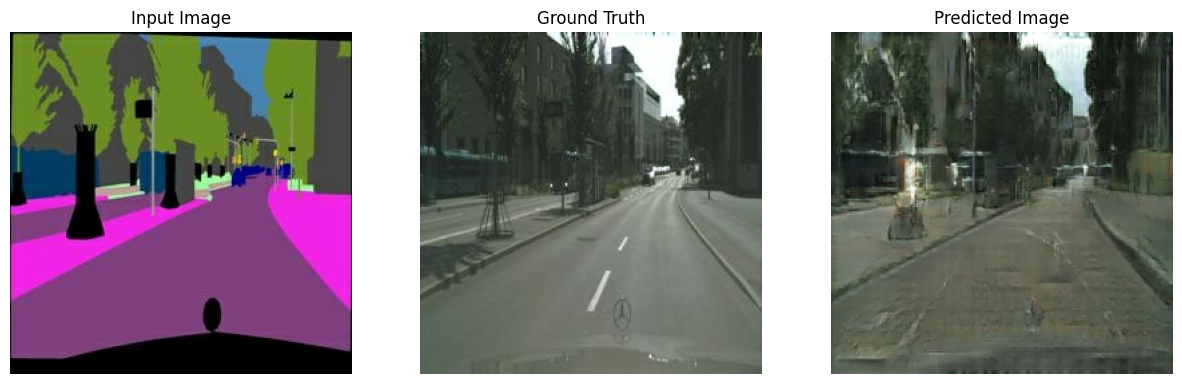

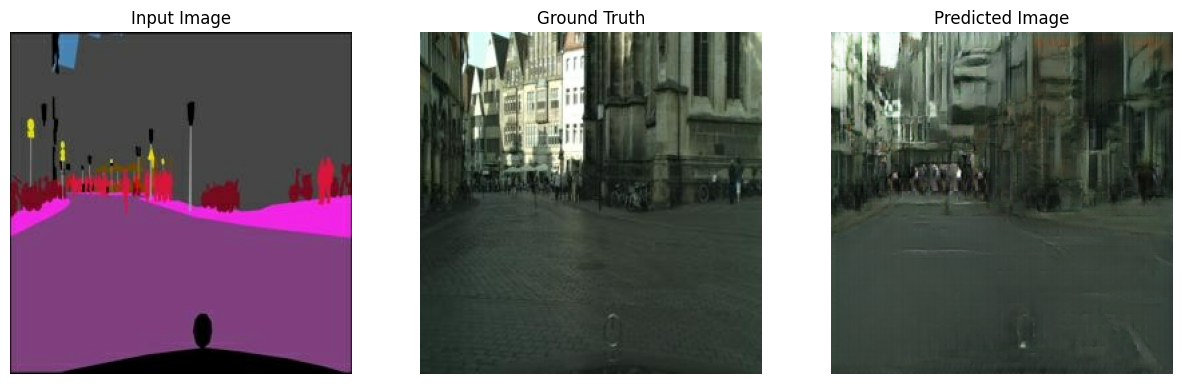

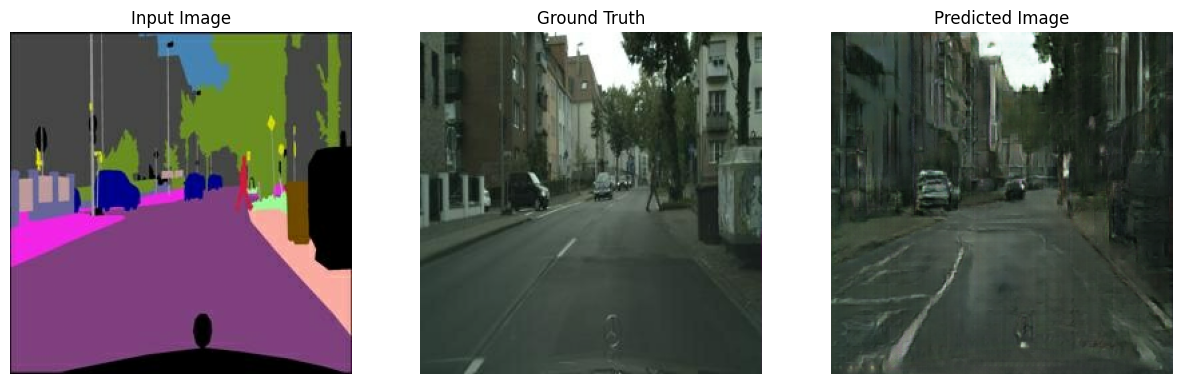

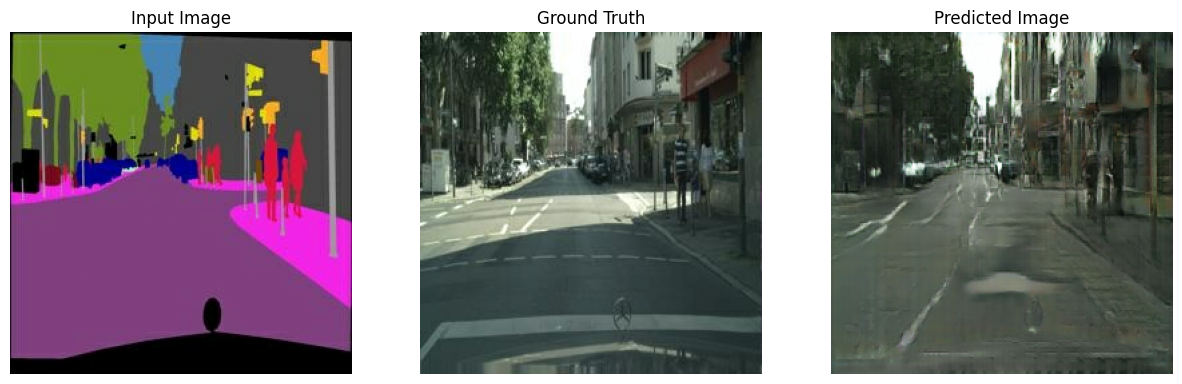

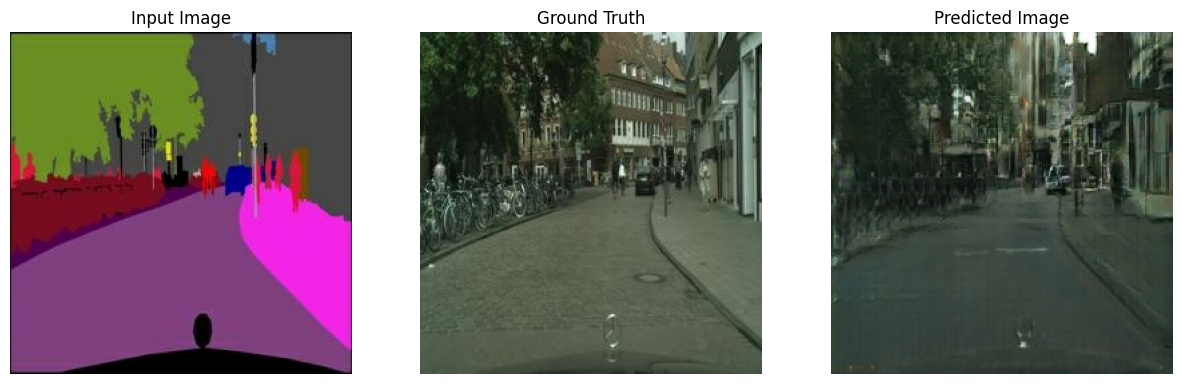

In [64]:
for inp, tar in val_ds.take(5):
    display_samples(generator_model, inp, tar)


## Plotting the Losses

Not we can plotrain and validation lossesefor discriminator and generator.e.


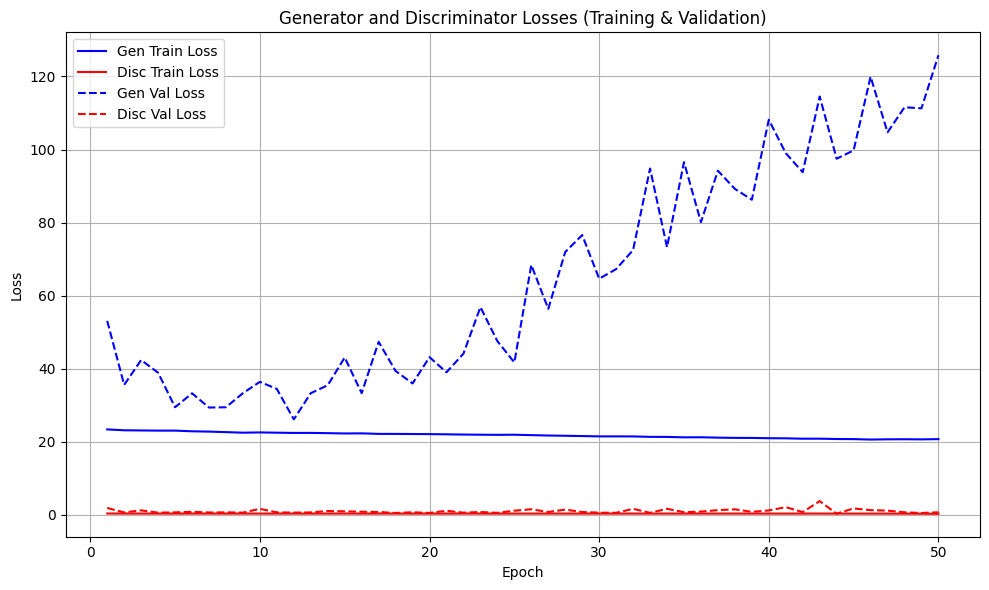

In [65]:
import matplotlib.pyplot as plt

def plot_losses(gen_loss_train, disc_loss_train, gen_loss_val, disc_loss_val):
    epochs = range(1, len(gen_loss_train) + 1)

    plt.figure(figsize=(10,6))
    plt.plot(epochs, gen_loss_train, 'b-', label='Gen Train Loss')
    plt.plot(epochs, disc_loss_train, 'r-', label='Disc Train Loss')
    plt.plot(epochs, gen_loss_val, 'b--', label='Gen Val Loss')
    plt.plot(epochs, disc_loss_val, 'r--', label='Disc Val Loss')

    plt.title('Generator and Discriminator Losses (Training & Validation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_losses(gen_loss_train_history, disc_loss_train_history, gen_loss_val_history, disc_loss_val_history)


## Conclusion

This notebook demonstrated the Pix2Pix framework ocityscapes-pix2pix-datasetes. We implemented a Conditional GAN that learns to translate segmentation maps into photorealistic images using adversarial training and an L1 penalty for better alignment with the target.

Notebook executis ion comp up to here and the rest is the answers to some questions asked in the assignment!ete.
